In [1]:
#import the required python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [7]:
import nltk #natural langugage processing
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA #Sentiment analysis
nltk.download('vader_lexicon')# download VADER lexicon
from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\I355833\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\I355833\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load and cleanup the Dataset

In [2]:
# load the data into the datafreame 

df = pd.read_csv("iphone15-reviews.csv")
df.head()

,text,start,duration
0,"- Hey, it's Justine and\ntoday we are checking...",0.000,1.710
1,the brand new iPhone 15.,1.710,1.740
2,We've got the Plus in green,3.450,1.590
3,"and the regular iPhone 15 in pink,",5.040,2.493
4,which obviously we know\nthat I'm excited about.,8.698,1.442


In [5]:
df.isnull().sum()

text        0
start       0
duration    0
dtype: int64

<Axes: >

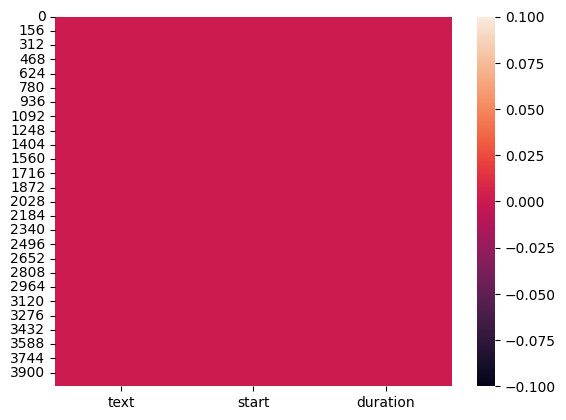

In [3]:
sns.heatmap(df.isnull())

### Set the default style for the graphs

In [8]:
# Set the plotting style to 'darkgrid'.
sns.set_style('darkgrid')

# Create an instance of the SentimentIntensityAnalyzer for sentiment analysis.
sia = SIA()

# Get the stopwords for the Portuguese language.
stpwrds = stopwords.words('english')

# Define a custom color map for sentiment categories based on Kaggle palette.
custom_colors_map = {'Negative':'#FFA07A','Neutral':'#FFFFFF', 'Positive':'#20BEFF'}

In [9]:
#General transformation in the text
import re

# General transformation in the text
def transformation(df, mc):
    # mc = main_column
    
    df[mc] = df[mc].str.lower()
    df[mc] = df[mc].apply(lambda x: re.sub('@[^\s]+', '', x))
    df[mc] = df[mc].apply(lambda x: re.sub(r'\B#\S+', '', x))
    df[mc] = df[mc].apply(lambda x: re.sub(r"http\S+", "", x))
    df[mc] = df[mc].apply(lambda x: ' '.join(re.findall(r'\w+', x)))
    df[mc] = df[mc].apply(lambda x: re.sub(r'\s+[b-zA-Z]\s+', ' ', x))
    df[mc] = df[mc].apply(lambda x: re.sub(r'\s+', ' ', x, flags=re.I))
    df[mc] = df[mc].apply(lambda x: ' '.join([word for word in x.split() if word not in stpwrds]))

    df['words'] = df[mc].apply(lambda x: re.findall(r'\w+', x))
    df['words_count'] = df.words.apply(len)
    df['length'] = df[mc].apply(len)

    return df

In [10]:
df.dtypes

text         object
start       float64
duration    float64
dtype: object

In [11]:
df['text'] = df['text'].astype("str")
df['start'] = df["start"].astype("float")
df['duration'] = df["start"].astype("float")

In [12]:
data = transformation(df,'text')

In [13]:
data.head()

,text,start,duration,words,words_count,length
0,hey justine today checking,0.000,0.000,"[hey, justine, today, checking]",4,26
1,brand new iphone 15,1.710,1.710,"[brand, new, iphone, 15]",4,19
2,got plus green,3.450,3.450,"[got, plus, green]",3,14
3,regular iphone 15 pink,5.040,5.040,"[regular, iphone, 15, pink]",4,22
4,obviously know excited,8.698,8.698,"[obviously, know, excited]",3,22


## Sentiment Analysis

In [15]:
def sentiment_classification(x:float):
    return 'Negative' if x < -0.25 else 'Positive' if x > 0.25 else 'Neutral'

data['sentiment_eval'] = [sia.polarity_scores(x)['compound'] for x in (data['text'])]
data['class_sentiment'] = data['sentiment_eval'].apply(sentiment_classification)

In [16]:
data.head()

,text,start,duration,words,words_count,length,sentiment_eval,class_sentiment
0,hey justine today checking,0.000,0.000,"[hey, justine, today, checking]",4,26,0.00,Neutral
1,brand new iphone 15,1.710,1.710,"[brand, new, iphone, 15]",4,19,0.00,Neutral
2,got plus green,3.450,3.450,"[got, plus, green]",3,14,0.00,Neutral
3,regular iphone 15 pink,5.040,5.040,"[regular, iphone, 15, pink]",4,22,0.00,Neutral
4,obviously know excited,8.698,8.698,"[obviously, know, excited]",3,22,0.34,Positive


### Count by Sentiment

In [17]:
#Funtion to create a custom histogram

def senti_plot(df):
    
    fig = px.histogram(
    df['class_sentiment'],
    y="class_sentiment",
    title=f'Sentiment Analysis from reviews',
    color='class_sentiment',
    color_discrete_map=custom_colors_map
    )

    # Customize the hover template to display the sentiment and count.
    fig.update_traces(hovertemplate='%{y}<br>Count: %{x}')

    # Update the layout with additional configurations.
    fig.update_layout(template='plotly_dark', title_x=0.5, yaxis_title='Sentiment', xaxis_title='Count', legend_title='Sentiment')

    # Display the figure.
    return fig

In [18]:
senti_plot(data)

In [19]:
from wordcloud import WordCloud 

In [20]:
# Function to flatten a nested list.
def flatten_list(l):
    return [x for y in l for x in y]

# Function to generate a colored WordCloud.
def generate_word_cloud(text, color_func, title, ax):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black", color_func=color_func).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=30)
    ax.axis("off")

# Function to generate word clouds.
def generate_word_clouds(pos_doc, neu_doc, neg_doc):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))  # Change to 1 row and 3 columns

    titles = ["Positive Words", "Neutral Words", "Negative Words"]
    docs = [pos_doc, neu_doc, neg_doc]
    color_funcs = [lambda *args, **kwargs: custom_colors_map['Positive'],
                   lambda *args, **kwargs: custom_colors_map['Neutral'],
                   lambda *args, **kwargs: custom_colors_map['Negative']]

    for i, (doc, color_func, title) in enumerate(zip(docs, color_funcs, titles)):
        generate_word_cloud(" ".join(doc), color_func, title, axes[i])

    plt.tight_layout()
    plt.show()

def word_clouds(df):
    # Sort data by 'hour' in descending order.
    sentiment_sorted = df.sort_values('start', ascending=False)

    # Get top 100 records for each sentiment category
    positive_top_100 = sentiment_sorted[sentiment_sorted['class_sentiment'] == "Positive"].iloc[:100]
    negative_top_100 = sentiment_sorted[sentiment_sorted['class_sentiment'] == "Negative"].iloc[:100]
    neutral_top_100 = sentiment_sorted[sentiment_sorted['class_sentiment'] == "Neutral"].iloc[:100]

    # Function to remove stopwords.
    cleanup = lambda x: [y for y in x.split() if y not in stpwrds]
    neg_doc = flatten_list(negative_top_100['text'].apply(cleanup))
    pos_doc = flatten_list(positive_top_100['text'].apply(cleanup))
    neu_doc = flatten_list(neutral_top_100['text'].apply(cleanup))

    # Generate word clouds using the cleaned document lists.
    generate_word_clouds(pos_doc, neu_doc, neg_doc)

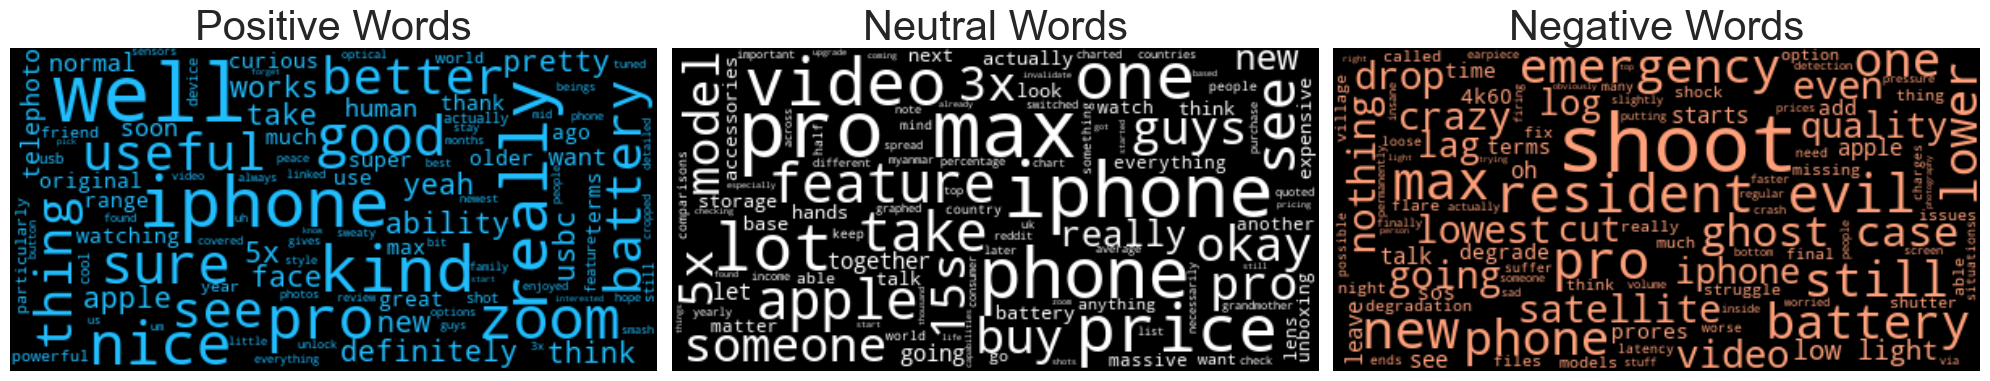

In [21]:
# Word clouds from review.
word_clouds(data)